In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import urllib3
urllib3.disable_warnings()

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1) ResNet 구성하기

---

### 전체적인 구조

![res](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

### plain과 residual 형태 비교

![1-1](https://github.com/JHyeok-Choi/AIFFEL/assets/119499530/33f09927-3fe8-4a42-84d4-2d6787ee2907)

### ResNet 34 와 54 의 residual 구조 차이

![1-2](https://github.com/JHyeok-Choi/AIFFEL/assets/119499530/f851976e-4760-4083-a8ef-780dc96af3c0)

In [3]:
# ResNet Block 함수

# Conv2D layer의 반복사용되는 부분.
def conv2d_block(x, channel, kernel_size, strides=1, name=False, add=False):
    
    x = keras.layers.Conv2D(filters=channel, kernel_size=kernel_size, activation='relu',
                            padding='same', strides=strides, name=name + '_conv')(x)
    x = keras.layers.BatchNormalization(name=name + '_bn')(x)
        
    if not add:
        x = keras.layers.Activation('relu', name=name + '_relu')(x)
    
    return x


def build_resnet_block(input_layer, num_cnn=3, channel=64, is_50=False, is_plain=False, block_num=1):
    # 입력 레이어
    x = input_layer
    a = x
    
    # CNN 레이어
    if is_50:
        for cnn_num in range(1, num_cnn+1):
            if cnn_num == 1:
                a = conv2d_block(a, channel * 4, 1, strides=2 if block_num != 2 else 1,
                                 name=f'conv{block_num}_block{cnn_num}_0', add=True)
                
            x = conv2d_block(x, channel, 1, strides=2 if block_num != 2 and cnn_num == 1 else 1,
                             name=f'conv{block_num}_block{cnn_num}_1_conv')
            x = conv2d_block(x, channel, 3, name=f'conv{block_num}_block{cnn_num}_2_conv')
            x = conv2d_block(x, channel * 4, 1, name=f'conv{block_num}_block{cnn_num}_3_conv', add=True)
            
            if not is_plain:
                x = keras.layers.Add(name=f'conv{block_num}_block{cnn_num}_add')([a, x])
            x = keras.layers.Activation('relu', name=f'conv{block_num}_block{cnn_num}_out')(x)
                
    else:
        for cnn_num in range(1, num_cnn + 1):
            if block_num >= 3 and cnn_num == 1:
                a = conv2d_block(a, channel, 1, strides=2,
                                 name=f'conv{block_num}_block{cnn_num}_0_short', add=True)
            
            x = conv2d_block(x, channel, 3, strides=2 if block_num != 2 and cnn_num == 1 else 1,
                             name=f'conv{block_num}_block{cnn_num}_1_conv')
            x = conv2d_block(x, channel, 3, name=f'conv{block_num}_block{cnn_num}_2_conv', add=True)
            
            if not is_plain:
                x = keras.layers.Add(name=f'conv{block_num}_block{cnn_num}_add')([a, x])
            x = keras.layers.Activation('relu', name=f'conv{block_num}_block{cnn_num}_out')(x)
                
        
    return x

In [4]:
# Res 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3), num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512], num_classes=10, is_50=False, is_plain=False):
    
    # 모델을 만들기 전에 config list 들이 같은 길이인지 확인합니다.
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name=f'input_layer')  # input layer를 만들어둡니다.
    
    # conv1
    output = conv2d_block(input_layer, 64, 7, strides= 2, name=f'conv1')
    
    # conv2_0 MaxPooling
    output = keras.layers.MaxPooling2D(pool_size=(2, 2), strides= 2, name=f'pool1_pool')(output)
    
    # config list 들의 길이만큼 반복해서 블록을 생성합니다.
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list), start=2):
        output = build_resnet_block(output, num_cnn=num_cnn, channel=channel, is_50=is_50, is_plain=is_plain, block_num=i)
    
    output = keras.layers.GlobalAveragePooling2D(name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

## ResNet-34

In [5]:
res_34 = build_resnet(input_shape=(32, 32, 3))
res_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 16, 16, 64)   0           conv1_bn[0][0]                   
______________________________________________________________________________________________

## ResNet-50

In [6]:
res_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
res_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 16, 16, 64)   0           conv1_bn[0][0]                   
____________________________________________________________________________________________

# 3) 일반 네트워크(plain network) 만들기

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [7]:
plainnet_34 = build_resnet(input_shape=(224, 224, 3), is_plain=True)
plainnet_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_block1_1_conv_conv (Co (None, 56, 56, 64)        36928     
_________________________________________________________________
conv2_block1_1_conv_bn (Batc (None, 56, 56, 64)        256 

In [8]:
plainnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=True)
plainnet_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_block1_1_conv_conv (Co (None, 56, 56, 64)        4160      
_________________________________________________________________
conv2_block1_1_conv_bn (Batc (None, 56, 56, 64)        256 

# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

---

## 데이터셋 준비

In [9]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765")

In [10]:
#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:75%]', 'train[75%:]'],
    shuffle_files=True,
    with_info=True,
)

In [11]:
ds_train

<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), label: ()}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64}>

In [12]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
ds_train

<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), label: ()}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64}>

In [14]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
train_len = int(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))
test_len = int(tf.data.experimental.cardinality(ds_test))

tf.Tensor(17446, shape=(), dtype=int64)
tf.Tensor(5816, shape=(), dtype=int64)


In [15]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [17]:
ds_info.features["label"].num_classes

2

In [18]:
ds_info.features["label"].names

['cat', 'dog']

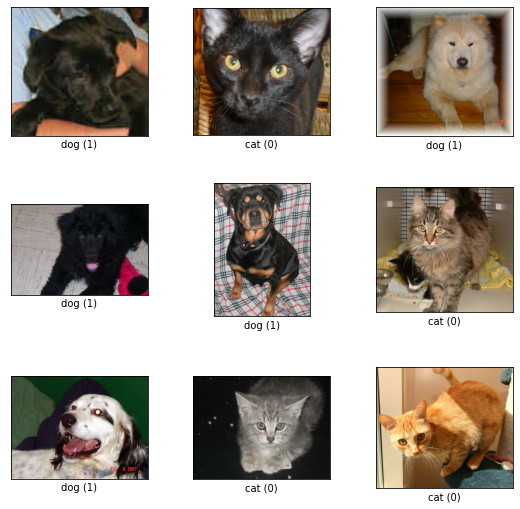

In [19]:
fig = tfds.show_examples(ds_train, ds_info)

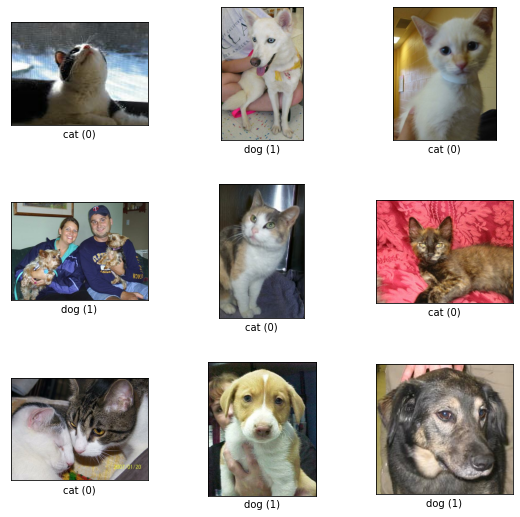

In [20]:
fig = tfds.show_examples(ds_test, ds_info)

In [21]:
BATCH_SIZE = 16
EPOCH = 3

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:75%]', 'train[75%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [23]:
ds_train

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [24]:
resnet_34 = build_resnet(input_shape=(224, 224, 3))

resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(train_len/BATCH_SIZE),
    validation_steps=int(test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3
 138/1090 [==>...........................] - ETA: 1:38 - loss: 1.0176 - accuracy: 0.5249

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 208/1090 [====>.........................] - ETA: 1:31 - loss: 0.9255 - accuracy: 0.5484

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 356/1090 [========>.....................] - ETA: 1:15 - loss: 0.8378 - accuracy: 0.5588

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 768/1090 [====================>.........] - ETA: 32s - loss: 0.7617 - accuracy: 0.5659

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 789/1090 [====================>.........] - ETA: 30s - loss: 0.7601 - accuracy: 0.5646

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 818/1090 [=====================>........] - ETA: 27s - loss: 0.7576 - accuracy: 0.5647

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 872/1090 [=======================>......] - ETA: 22s - loss: 0.7525 - accuracy: 0.5664

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 884/1090 [=======================>......] - ETA: 21s - loss: 0.7519 - accuracy: 0.5662

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.5737

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 160s 116ms/step - loss: 0.7364 - accuracy: 0.5737 - val_loss: 0.7021 - val_accuracy: 0.6002
Epoch 2/3
 139/1090 [==>...........................] - ETA: 1:41 - loss: 0.6715 - accuracy: 0.6025

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 209/1090 [====>.........................] - ETA: 1:32 - loss: 0.6774 - accuracy: 0.5954

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 357/1090 [========>.....................] - ETA: 1:16 - loss: 0.6788 - accuracy: 0.5931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 768/1090 [====================>.........] - ETA: 33s - loss: 0.6787 - accuracy: 0.5901

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 791/1090 [====================>.........] - ETA: 30s - loss: 0.6791 - accuracy: 0.5893

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 818/1090 [=====================>........] - ETA: 27s - loss: 0.6797 - accuracy: 0.5893

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 872/1090 [=======================>......] - ETA: 22s - loss: 0.6800 - accuracy: 0.5887

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 884/1090 [=======================>......] - ETA: 21s - loss: 0.6800 - accuracy: 0.5891

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.5907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 125s 115ms/step - loss: 0.6785 - accuracy: 0.5907 - val_loss: 0.8754 - val_accuracy: 0.5305
Epoch 3/3
 139/1090 [==>...........................] - ETA: 1:36 - loss: 0.6711 - accuracy: 0.6021

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 215/1090 [====>.........................] - ETA: 1:29 - loss: 0.6726 - accuracy: 0.5919

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 358/1090 [========>.....................] - ETA: 1:14 - loss: 0.6752 - accuracy: 0.5967

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 768/1090 [====================>.........] - ETA: 32s - loss: 0.6786 - accuracy: 0.5876

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 797/1090 [====================>.........] - ETA: 29s - loss: 0.6783 - accuracy: 0.5874

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 818/1090 [=====================>........] - ETA: 27s - loss: 0.6778 - accuracy: 0.5885

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 872/1090 [=======================>......] - ETA: 22s - loss: 0.6781 - accuracy: 0.5880

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 885/1090 [=======================>......] - ETA: 20s - loss: 0.6783 - accuracy: 0.5881

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.5870

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 124s 114ms/step - loss: 0.6775 - accuracy: 0.5870 - val_loss: 0.8376 - val_accuracy: 0.5616


In [25]:
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(train_len/BATCH_SIZE),
    validation_steps=int(test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3
 141/1090 [==>...........................] - ETA: 1:32 - loss: 1.4010 - accuracy: 0.5102

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 211/1090 [====>.........................] - ETA: 1:25 - loss: 1.2387 - accuracy: 0.5270

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 353/1090 [========>.....................] - ETA: 1:12 - loss: 1.0609 - accuracy: 0.5386

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 770/1090 [====================>.........] - ETA: 31s - loss: 0.8747 - accuracy: 0.5309

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 793/1090 [====================>.........] - ETA: 28s - loss: 0.8696 - accuracy: 0.5314

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 814/1090 [=====================>........] - ETA: 26s - loss: 0.8653 - accuracy: 0.5322

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 868/1090 [======================>.......] - ETA: 21s - loss: 0.8553 - accuracy: 0.5328

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 880/1090 [=======================>......] - ETA: 20s - loss: 0.8534 - accuracy: 0.5327

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.8253 - accuracy: 0.5325

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 127s 110ms/step - loss: 0.8253 - accuracy: 0.5325 - val_loss: 0.9752 - val_accuracy: 0.4926
Epoch 2/3
 139/1090 [==>...........................] - ETA: 1:32 - loss: 0.7076 - accuracy: 0.5162

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 213/1090 [====>.........................] - ETA: 1:25 - loss: 0.7072 - accuracy: 0.5211

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 354/1090 [========>.....................] - ETA: 1:11 - loss: 0.7029 - accuracy: 0.5332

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 771/1090 [====================>.........] - ETA: 31s - loss: 0.7006 - accuracy: 0.5364

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 794/1090 [====================>.........] - ETA: 28s - loss: 0.7006 - accuracy: 0.5372

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 814/1090 [=====================>........] - ETA: 26s - loss: 0.7010 - accuracy: 0.5368

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 868/1090 [======================>.......] - ETA: 21s - loss: 0.7005 - accuracy: 0.5373

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 881/1090 [=======================>......] - ETA: 20s - loss: 0.7008 - accuracy: 0.5367

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.7001 - accuracy: 0.5387

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 119s 109ms/step - loss: 0.7001 - accuracy: 0.5387 - val_loss: 0.8858 - val_accuracy: 0.5234
Epoch 3/3
 141/1090 [==>...........................] - ETA: 1:32 - loss: 0.6900 - accuracy: 0.5603

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 214/1090 [====>.........................] - ETA: 1:25 - loss: 0.6950 - accuracy: 0.5496

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 355/1090 [========>.....................] - ETA: 1:11 - loss: 0.6968 - accuracy: 0.5400

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 767/1090 [====================>.........] - ETA: 31s - loss: 0.6998 - accuracy: 0.5332

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 795/1090 [====================>.........] - ETA: 28s - loss: 0.6996 - accuracy: 0.5331

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 820/1090 [=====================>........] - ETA: 26s - loss: 0.6994 - accuracy: 0.5328

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 874/1090 [=======================>......] - ETA: 21s - loss: 0.6994 - accuracy: 0.5333

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 887/1090 [=======================>......] - ETA: 19s - loss: 0.6993 - accuracy: 0.5330

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.5345

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 119s 109ms/step - loss: 0.6990 - accuracy: 0.5345 - val_loss: 0.8253 - val_accuracy: 0.5064


In [26]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)

resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(train_len/BATCH_SIZE),
    validation_steps=int(train_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
 136/1090 [==>...........................] - ETA: 2:55 - loss: 1.0144 - accuracy: 0.5207

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 207/1090 [====>.........................] - ETA: 2:42 - loss: 0.9362 - accuracy: 0.5257

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 353/1090 [========>.....................] - ETA: 2:14 - loss: 0.8584 - accuracy: 0.5397

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 770/1090 [====================>.........] - ETA: 58s - loss: 0.7807 - accuracy: 0.5468

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 789/1090 [====================>.........] - ETA: 54s - loss: 0.7782 - accuracy: 0.5482

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 816/1090 [=====================>........] - ETA: 50s - loss: 0.7751 - accuracy: 0.5499

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 870/1090 [======================>.......] - ETA: 40s - loss: 0.7703 - accuracy: 0.5518

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 882/1090 [=======================>......] - ETA: 37s - loss: 0.7692 - accuracy: 0.5526

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.5579

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 272s 237ms/step - loss: 0.7539 - accuracy: 0.5579 - val_loss: 0.7206 - val_accuracy: 0.5774
Epoch 2/3
 135/1090 [==>...........................] - ETA: 2:54 - loss: 0.6880 - accuracy: 0.5852

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 216/1090 [====>.........................] - ETA: 2:39 - loss: 0.6838 - accuracy: 0.5891

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 355/1090 [========>.....................] - ETA: 2:14 - loss: 0.6827 - accuracy: 0.5836

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 766/1090 [====================>.........] - ETA: 59s - loss: 0.6834 - accuracy: 0.5892

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 798/1090 [====================>.........] - ETA: 53s - loss: 0.6838 - accuracy: 0.5875

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 815/1090 [=====================>........] - ETA: 50s - loss: 0.6838 - accuracy: 0.5872

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 869/1090 [======================>.......] - ETA: 40s - loss: 0.6843 - accuracy: 0.5872

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 881/1090 [=======================>......] - ETA: 38s - loss: 0.6836 - accuracy: 0.5878

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5855

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 257s 236ms/step - loss: 0.6853 - accuracy: 0.5855 - val_loss: 0.8508 - val_accuracy: 0.5545
Epoch 3/3
 141/1090 [==>...........................] - ETA: 2:52 - loss: 0.6829 - accuracy: 0.5904

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 210/1090 [====>.........................] - ETA: 2:40 - loss: 0.6827 - accuracy: 0.5866

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 344/1090 [========>.....................] - ETA: 2:15 - loss: 0.6832 - accuracy: 0.5886

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 773/1090 [====================>.........] - ETA: 57s - loss: 0.6782 - accuracy: 0.5948

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 792/1090 [====================>.........] - ETA: 54s - loss: 0.6776 - accuracy: 0.5947

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 823/1090 [=====================>........] - ETA: 48s - loss: 0.6780 - accuracy: 0.5943

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 877/1090 [=======================>......] - ETA: 38s - loss: 0.6783 - accuracy: 0.5945

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 888/1090 [=======================>......] - ETA: 36s - loss: 0.6786 - accuracy: 0.5941

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 256s 235ms/step - loss: 0.6804 - accuracy: 0.5932 - val_loss: 1.1950 - val_accuracy: 0.5316


In [27]:
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(train_len/BATCH_SIZE),
    validation_steps=int(test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3
 127/1090 [==>...........................] - ETA: 2:25 - loss: 1.3006 - accuracy: 0.5335

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 207/1090 [====>.........................] - ETA: 2:14 - loss: 1.1552 - accuracy: 0.5263

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 366/1090 [=========>....................] - ETA: 1:50 - loss: 0.9906 - accuracy: 0.5294

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 776/1090 [====================>.........] - ETA: 47s - loss: 0.8431 - accuracy: 0.5301

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 788/1090 [====================>.........] - ETA: 45s - loss: 0.8411 - accuracy: 0.5295

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 808/1090 [=====================>........] - ETA: 42s - loss: 0.8381 - accuracy: 0.5295

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 862/1090 [======================>.......] - ETA: 34s - loss: 0.8299 - accuracy: 0.5283

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 874/1090 [=======================>......] - ETA: 32s - loss: 0.8282 - accuracy: 0.5290

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.8048 - accuracy: 0.5242

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 195s 170ms/step - loss: 0.8048 - accuracy: 0.5242 - val_loss: 1.5522 - val_accuracy: 0.5279
Epoch 2/3
 142/1090 [==>...........................] - ETA: 2:24 - loss: 0.7130 - accuracy: 0.5106

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 211/1090 [====>.........................] - ETA: 2:13 - loss: 0.7114 - accuracy: 0.5139

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 342/1090 [========>.....................] - ETA: 1:53 - loss: 0.7089 - accuracy: 0.5177

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 772/1090 [====================>.........] - ETA: 48s - loss: 0.7079 - accuracy: 0.5229

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 792/1090 [====================>.........] - ETA: 45s - loss: 0.7081 - accuracy: 0.5222

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 817/1090 [=====================>........] - ETA: 41s - loss: 0.7083 - accuracy: 0.5221

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 871/1090 [======================>.......] - ETA: 33s - loss: 0.7089 - accuracy: 0.5217

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 882/1090 [=======================>......] - ETA: 31s - loss: 0.7091 - accuracy: 0.5208

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.5186

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 184s 169ms/step - loss: 0.7093 - accuracy: 0.5186 - val_loss: 0.7493 - val_accuracy: 0.5226
Epoch 3/3
 144/1090 [==>...........................] - ETA: 2:24 - loss: 0.7087 - accuracy: 0.5143

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 214/1090 [====>.........................] - ETA: 2:13 - loss: 0.7070 - accuracy: 0.5111

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 338/1090 [========>.....................] - ETA: 1:54 - loss: 0.7072 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 775/1090 [====================>.........] - ETA: 47s - loss: 0.7095 - accuracy: 0.5071

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 796/1090 [====================>.........] - ETA: 44s - loss: 0.7095 - accuracy: 0.5069

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 822/1090 [=====================>........] - ETA: 40s - loss: 0.7090 - accuracy: 0.5094

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 875/1090 [=======================>......] - ETA: 32s - loss: 0.7075 - accuracy: 0.5135

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 885/1090 [=======================>......] - ETA: 31s - loss: 0.7075 - accuracy: 0.5141

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1090/1090 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.5090

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1090/1090 [==============================] - 184s 169ms/step - loss: 0.7089 - accuracy: 0.5090 - val_loss: 0.9205 - val_accuracy: 0.5521


### 시각화

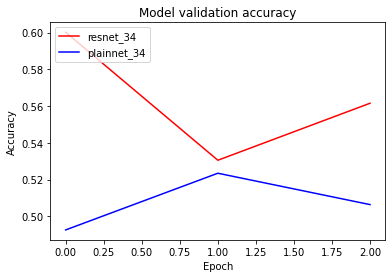

In [28]:
plt.plot(history_res_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

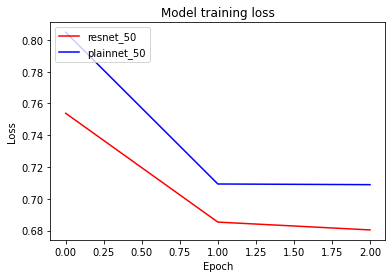

In [29]:
plt.plot(history_res_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

# 회고

* ResNet의 residual 유무의 차이를 확인해보는 프로젝트입니다.
* ResNet을 구현하는데 논문과 tensorflow.keras.layers 들의 정보만보면서 구현해보면서 모델구조와 각 레이어들의 이해가 더욱 깊어지는 재밌는 시간이었습니다.
* 훈련중 메모리가 부족한지 학습이 진행되다 말아서 epoch를 낮게 설정해서 테스트해보았지만, ResNet이 PlainNet보다 성능이 좋은것은 확인되었습니다.